In [1]:
import numpy as np
xs = np.random.rand(10000, 1, 3)
ys = np.reshape(xs, (10000, 3))

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, merge
from keras.optimizers import Adam

actor = Sequential()
actor.add(Flatten(input_shape=(1,3)))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(3))
actor.add(Activation('linear'))

Using TensorFlow backend.


In [3]:
actor.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

In [4]:
actor.fit(xs, ys, verbose=0)

In [6]:
import gym

from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess


ENV_NAME = 'Pendulum-v0'
gym.undo_logger_setup()


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

In [5]:
actor.pop()
actor.pop()

In [7]:
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))

In [10]:
print(actor.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_1 (Flatten)              (None, 3)             0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 16)            64          flatten_1[0][0]                  
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 16)            272         activation_1[0][0]               
___________________________________________________________________________________________

In [8]:
from keras import backend as K

In [9]:
inputs = actor.layers[0].input
outputs = actor.layers[4].output
AE = K.function([inputs], [outputs]) # activation_2までの重みが２度目のcompileによって初期化されてないか確認するため.

In [10]:
AE([xs]) # 1度のみcompile

[array([[ 0.        ,  0.21055388,  0.22661696, ...,  0.60111266,
          0.        ,  0.1850725 ],
        [ 0.        ,  0.38504863,  0.34697774, ...,  0.48960561,
          0.        ,  0.35830694],
        [ 0.        ,  0.3913824 ,  0.39638329, ...,  0.9554286 ,
          0.        ,  0.51516587],
        ..., 
        [ 0.        ,  0.28042817,  0.29858124, ...,  0.91953045,
          0.        ,  0.36432955],
        [ 0.        ,  0.49696815,  0.30077893, ...,  0.80536807,
          0.        ,  0.49955124],
        [ 0.        ,  0.27493322,  0.40006375, ...,  0.55155963,
          0.        ,  0.32230717]], dtype=float32)]

In [11]:
actor.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

In [12]:
inputs = actor.layers[0].input
outputs = actor.layers[4].output
AE = K.function([inputs], [outputs])

In [13]:
AE([xs]) # 2度compile 不変らしい.

[array([[ 0.        ,  0.21055388,  0.22661696, ...,  0.60111266,
          0.        ,  0.1850725 ],
        [ 0.        ,  0.38504863,  0.34697774, ...,  0.48960561,
          0.        ,  0.35830694],
        [ 0.        ,  0.3913824 ,  0.39638329, ...,  0.9554286 ,
          0.        ,  0.51516587],
        ..., 
        [ 0.        ,  0.28042817,  0.29858124, ...,  0.91953045,
          0.        ,  0.36432955],
        [ 0.        ,  0.49696815,  0.30077893, ...,  0.80536807,
          0.        ,  0.49955124],
        [ 0.        ,  0.27493322,  0.40006375, ...,  0.55155963,
          0.        ,  0.32230717]], dtype=float32)]

In [14]:
actor.predict(xs).shape

(10000, 1)

In [15]:
action_input = Input(shape=(nb_actions,), name='action_input') # 1なんですがおｋ?→４分の１だからいいか.
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = merge([action_input, flattened_observation], mode='concat')
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(input=[action_input, observation_input], output=x)
print(critic.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
# 3回目compileしてる？


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
observation_input (InputLayer)   (None, 1, 3)          0                                            
____________________________________________________________________________________________________
action_input (InputLayer)        (None, 1)             0                                            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 3)             0           observation_input[0][0]          
____________________________________________________________________________________________________
merge_1 (Merge)                  (None, 4)             0           action_input[0][0]               
                                                                   flatten_2[0][0]         

In [16]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
%time hist1 = agent.fit(env, nb_steps=20000, visualize=False, verbose=0, nb_max_episode_steps=200) #50000, True, 1, 200

CPU times: user 2min 41s, sys: 28 s, total: 3min 9s
Wall time: 1min 58s


In [30]:
# After training is done, we save the final weights.
# agent.save_weights('ddpg_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
agent.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=200)

Testing for 5 episodes ...
Episode 1: reward: -260.055, steps: 200
Episode 2: reward: -128.624, steps: 200
Episode 3: reward: -126.487, steps: 200
Episode 4: reward: -255.657, steps: 200
Episode 5: reward: -384.994, steps: 200


In [27]:
# original version. (random initialization)

actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = merge([action_input, flattened_observation], mode='concat')
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(input=[action_input, observation_input], output=x)
print(critic.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
agent.fit(env, nb_steps=20000, visualize=False, verbose=0, nb_max_episode_steps=200)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_3 (Flatten)              (None, 3)             0           flatten_input_3[0][0]            
____________________________________________________________________________________________________
dense_10 (Dense)                 (None, 16)            64          flatten_3[0][0]                  
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 16)            0           dense_10[0][0]                   
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 16)            272         activation_10[0][0]              
___________________________________________________________________________________________

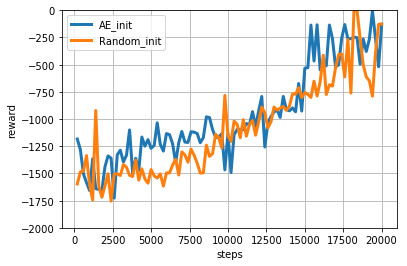

In [29]:
# Visualization
from matplotlib import pyplot
%matplotlib inline

pyplot.plot(hist1.history['nb_steps'], hist1.history['episode_reward'], linewidth=3, label='AE_init')
pyplot.plot(hist2.history['nb_steps'], hist2.history['episode_reward'], linewidth=3, label='Random_init')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('steps')
pyplot.ylabel('reward')
pyplot.ylim(-2000, -1)
#pyplot.yscale('log')
pyplot.show()

In [ ]:
# oh...